# Experiment 1.2
Looking for ImageNet classes that differ only in color.

## Concept
I want to see if a making a color-only change to an image is enough to trick a common ImageNet trained network into misclassifying. I use ResNet50, and I photoshop a lemon to have a different color (look more orange) in the hope of making the trained model to think it's looking at an orange. 

If I can trick both a human and the model, then I think this is a little bit of evidence that the model relies on color in a similar way to a human. If the model is _not_ tricked, yet a human is, then the model is not relying on color as strongly as a human would; the model is using other information and doesn't need the color information as much as the human. 

## tl;dr
The simple color edit can trick a human, but not the model.

## Notebook

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import json
import IPython
import cv2
import glob

In [2]:
def imshow(img):
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

### Interesting ImageNet class pairs 
Looking through the ImageNet classes, there are a few pairs that are similar, except for color differences:

- lemon (950) vs. orange (951)
- broccoli vs. cauliflower
- zuchini vs. cucumber

I think the best pair is (lemon, orange); as some oranges and lemons have very similar shapes and textures. Broccoli and cauliflower might be tricky too. I'll stick with the lemons and oranges as I think it will be easier for me to convincingly edit the colors of oranges or lemons in a photo.

For reference, the full list of ImageNet classes is: 

In [3]:
with open('./resources/imagenet-simple-labels.json') as f:
    labels = json.load(f)
    print(*enumerate(labels), sep='\n')

(0, 'tench')
(1, 'goldfish')
(2, 'great white shark')
(3, 'tiger shark')
(4, 'hammerhead shark')
(5, 'electric ray')
(6, 'stingray')
(7, 'cock')
(8, 'hen')
(9, 'ostrich')
(10, 'brambling')
(11, 'goldfinch')
(12, 'house finch')
(13, 'junco')
(14, 'indigo bunting')
(15, 'American robin')
(16, 'bulbul')
(17, 'jay')
(18, 'magpie')
(19, 'chickadee')
(20, 'American dipper')
(21, 'kite')
(22, 'bald eagle')
(23, 'vulture')
(24, 'great grey owl')
(25, 'fire salamander')
(26, 'smooth newt')
(27, 'newt')
(28, 'spotted salamander')
(29, 'axolotl')
(30, 'American bullfrog')
(31, 'tree frog')
(32, 'tailed frog')
(33, 'loggerhead sea turtle')
(34, 'leatherback sea turtle')
(35, 'mud turtle')
(36, 'terrapin')
(37, 'box turtle')
(38, 'banded gecko')
(39, 'green iguana')
(40, 'Carolina anole')
(41, 'desert grassland whiptail lizard')
(42, 'agama')
(43, 'frilled-necked lizard')
(44, 'alligator lizard')
(45, 'Gila monster')
(46, 'European green lizard')
(47, 'chameleon')
(48, 'Komodo dragon')
(49, 'Nile c

## ImageNet oranges and lemons 
Take a look at some of the specific training images.

### Oranges

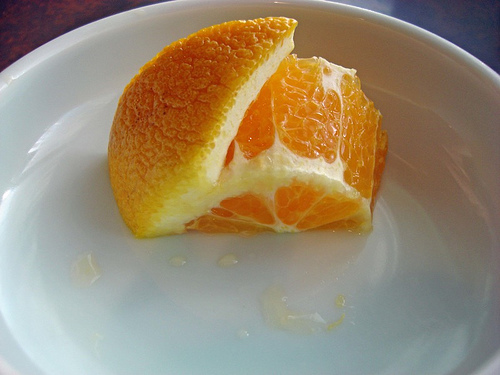

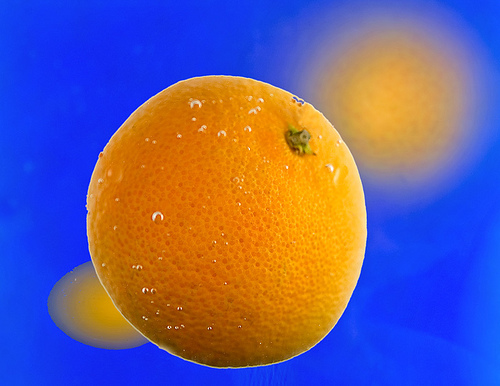

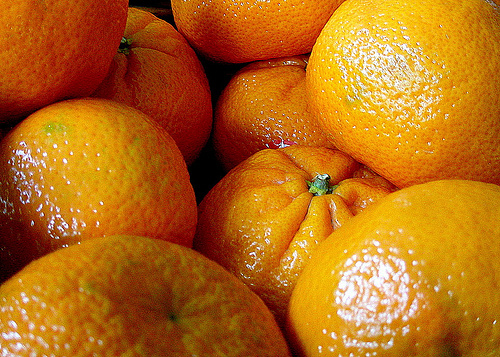

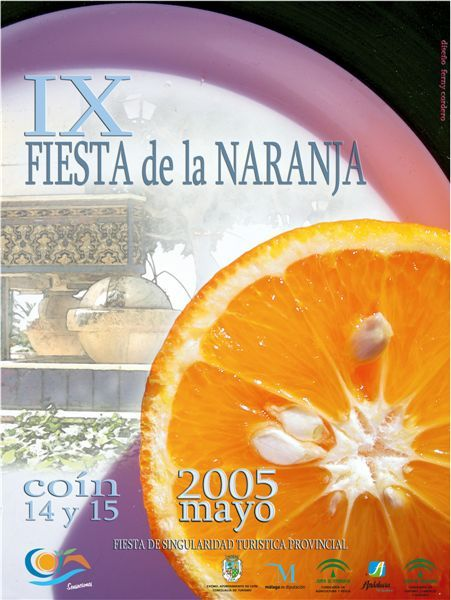

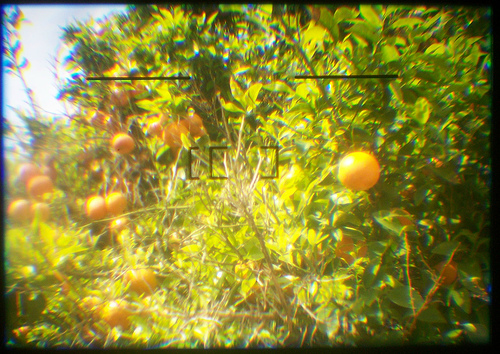

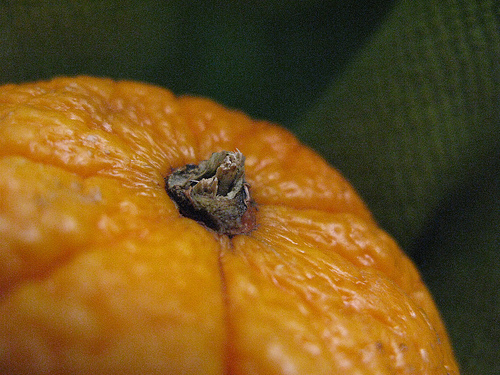

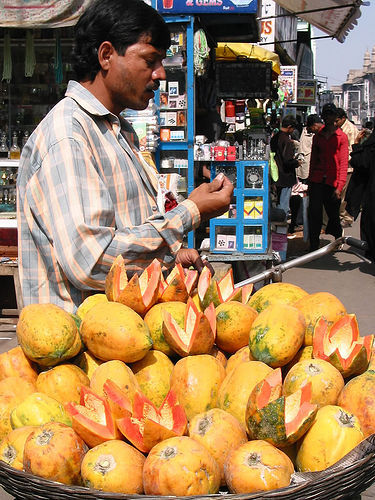

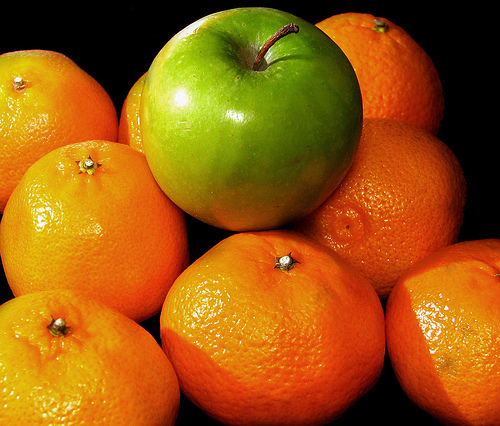

In [4]:
for imageName in glob.glob('resources/exp_1_2/imagenet_oranges/*'): #assuming JPG
    IPython.display.display(IPython.display.Image(filename=imageName))

### Lemons

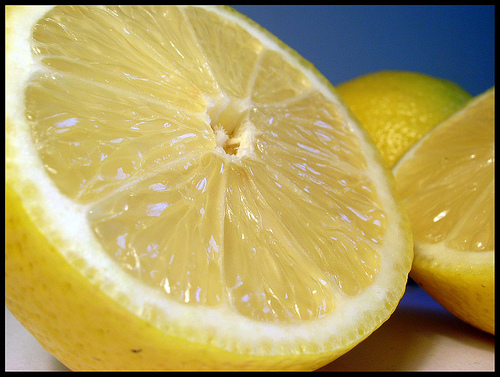

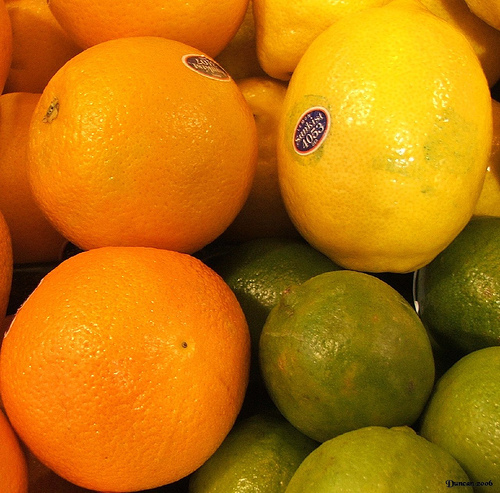

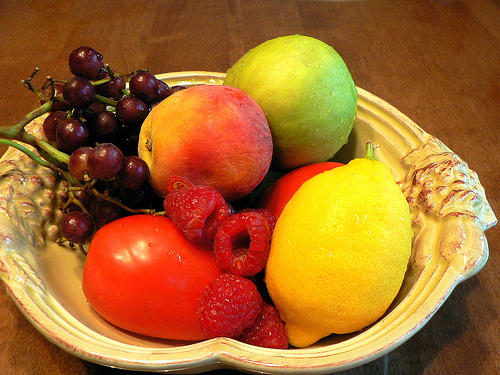

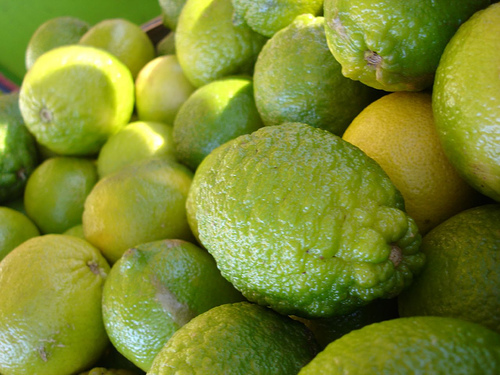

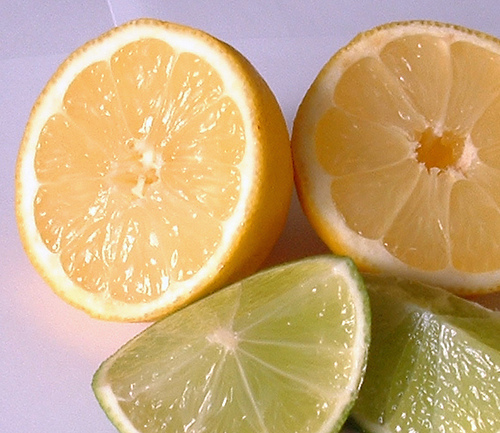

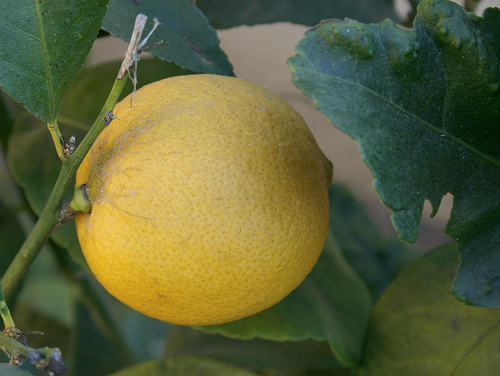

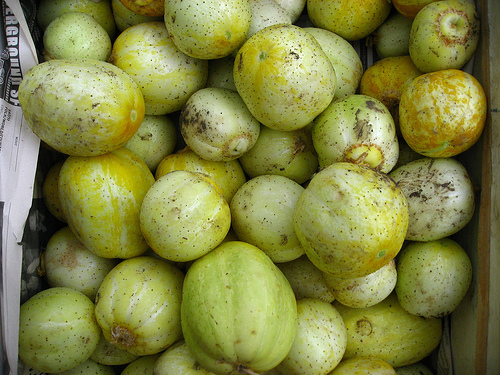

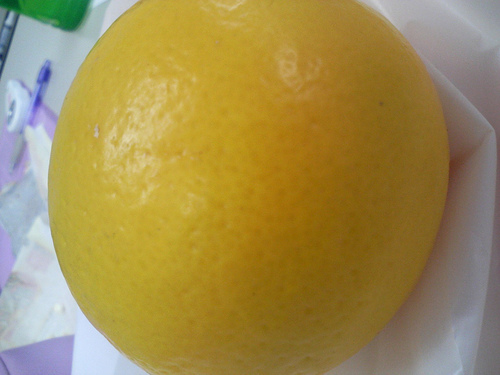

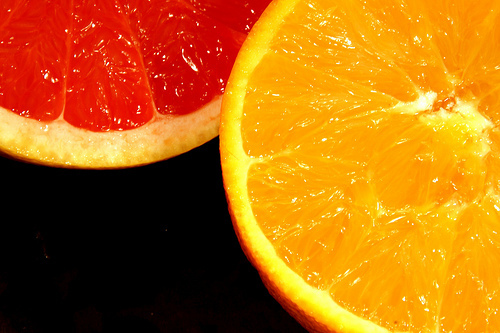

In [5]:
for imageName in glob.glob('resources/exp_1_2/imagenet_lemons/*'): #assuming JPG
    IPython.display.display(IPython.display.Image(filename=imageName))

### Not so easy
The images of oranges seem relatively easy. The photo of the oranges on the tree is the hardest for me. The images of of the lemons are hard! The last one I would have labeled as an orange. Maybe I'm printing the images incorrectly. Even so, there is a photo of oranges and lemons together, and no printing adjustments can make this distinction any easier. 

This is a little troubling as the experiment assumes the classes are not difficult to distinguish at the beginning. 

## Lemon to orange
I took a photo of a lemon, edited it in Inkscape to add a orange layer blended on top. The edit is a bit of a hack, but the effect is relatively effective to make the lemon look more like an orange (to my eye, at least, and the couple of people I asked).

Original lemon image:
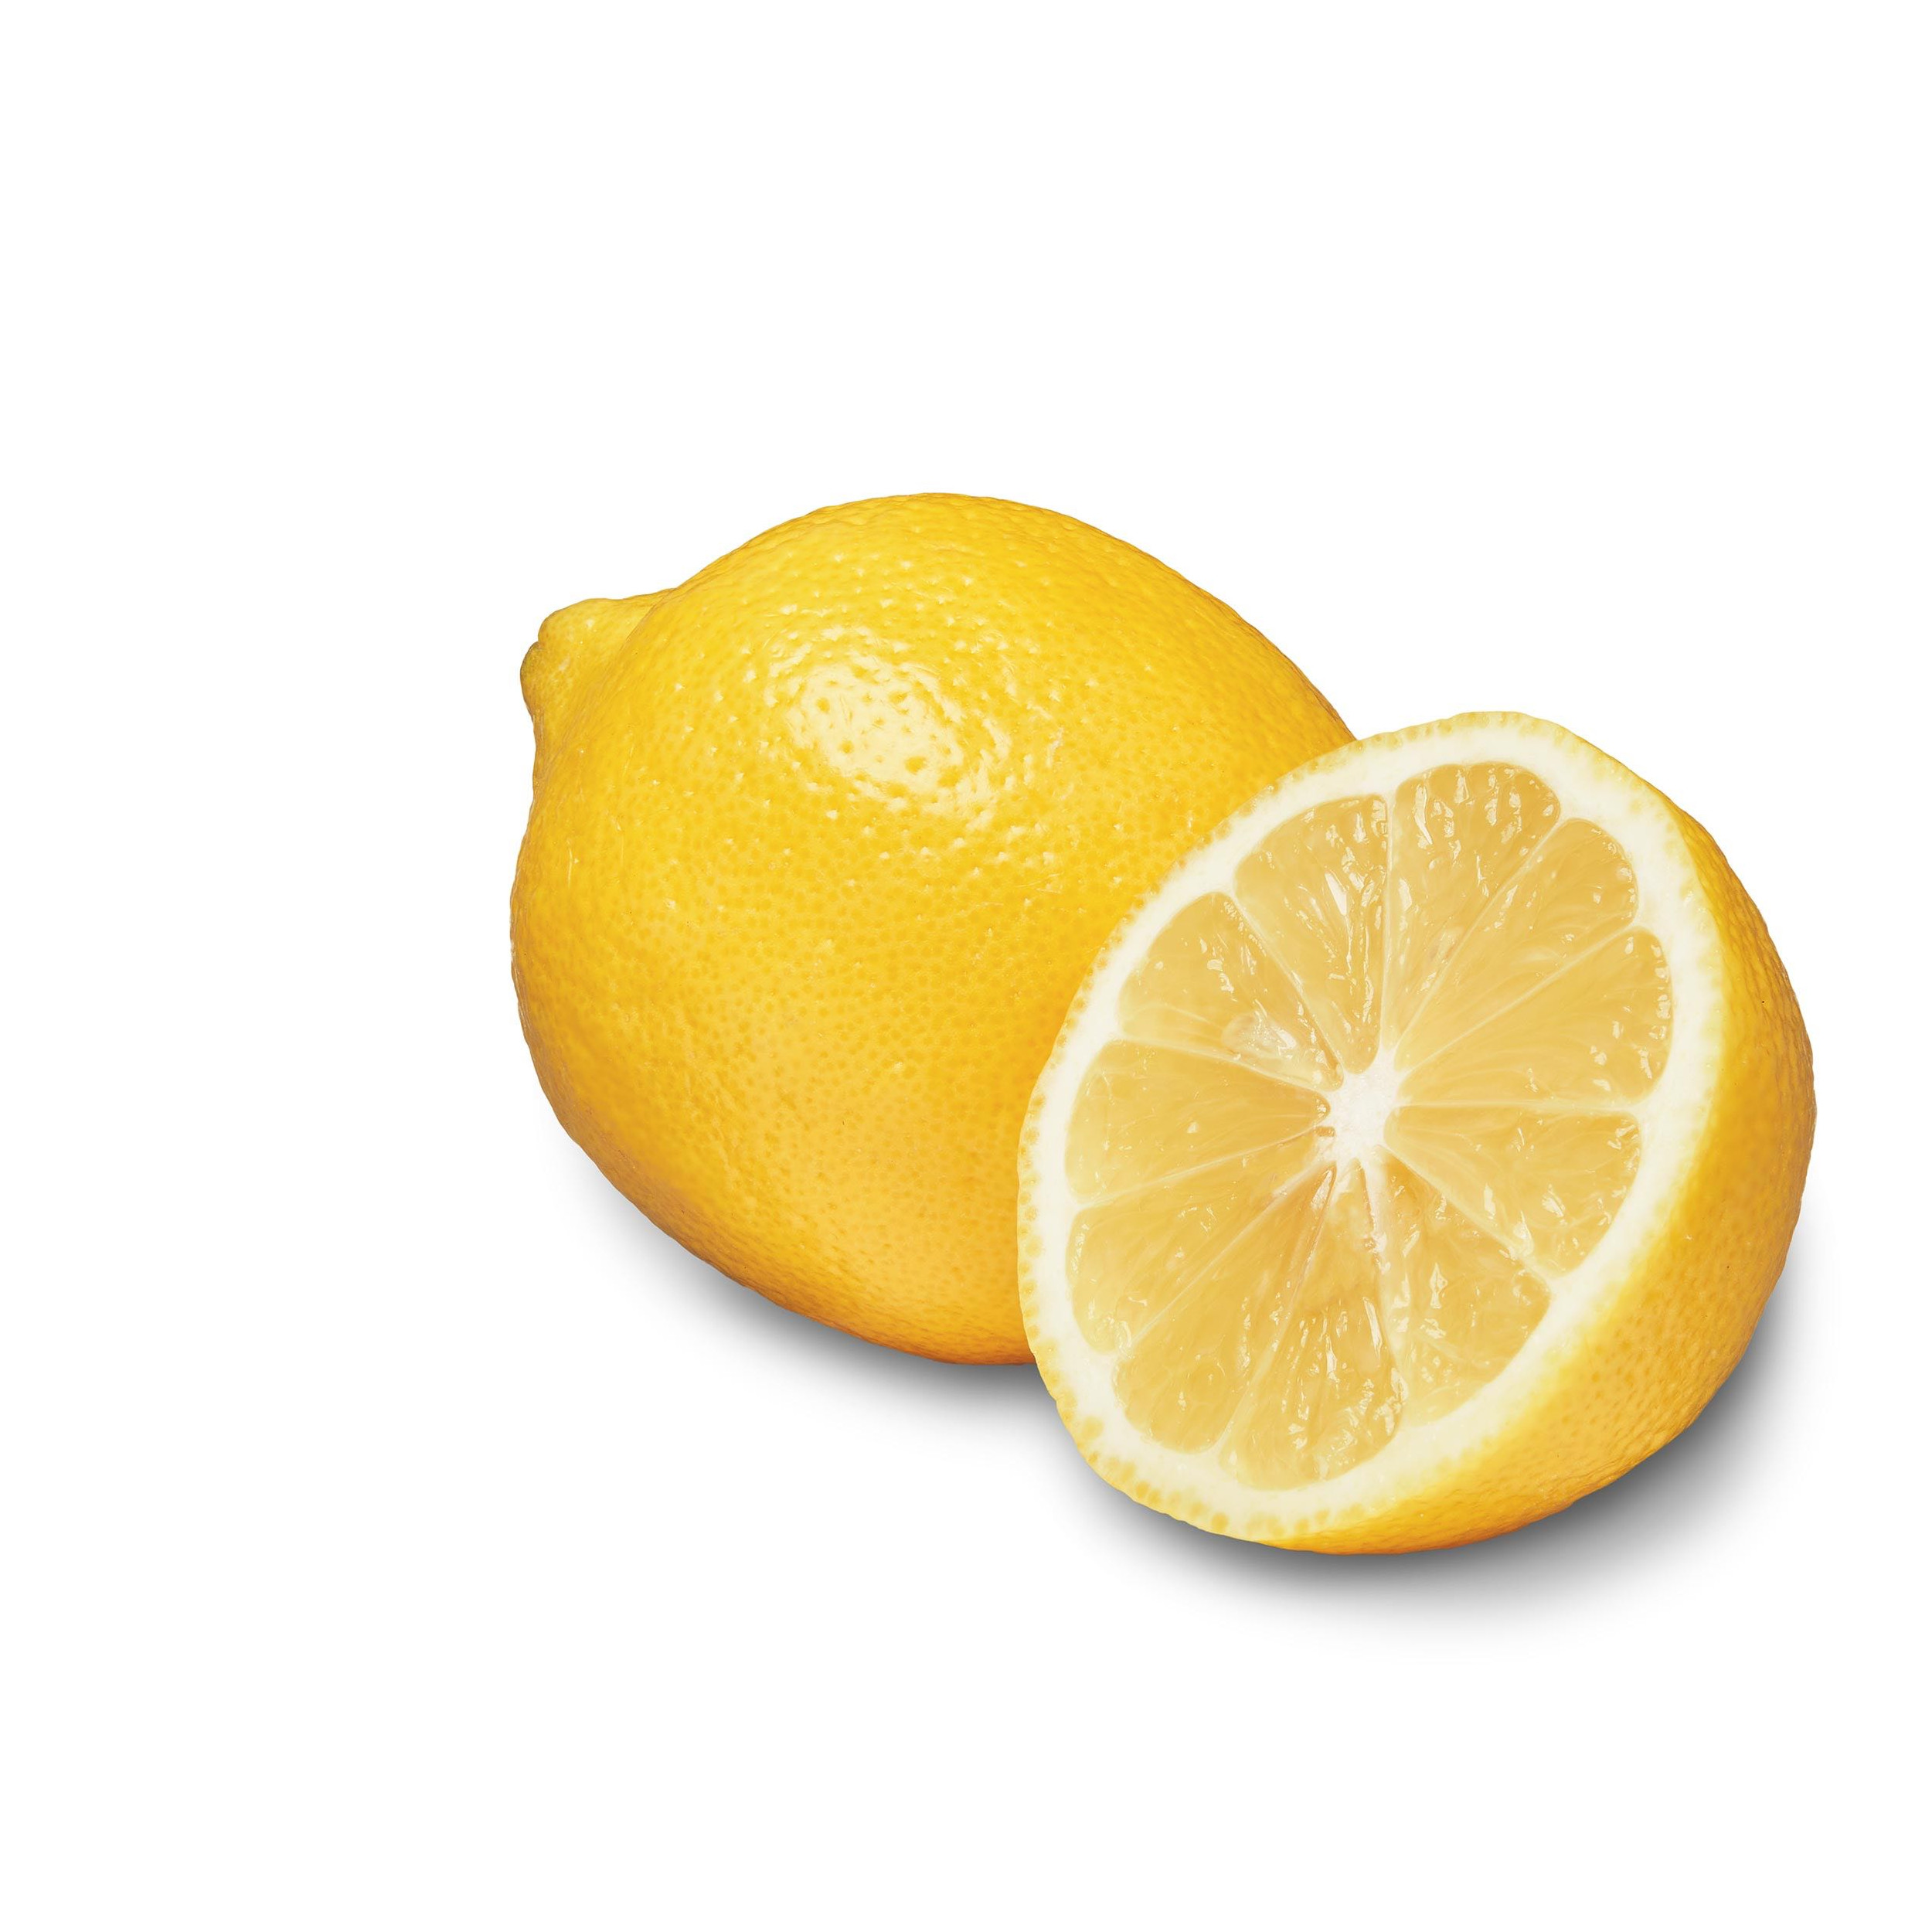

Edited with orange color:
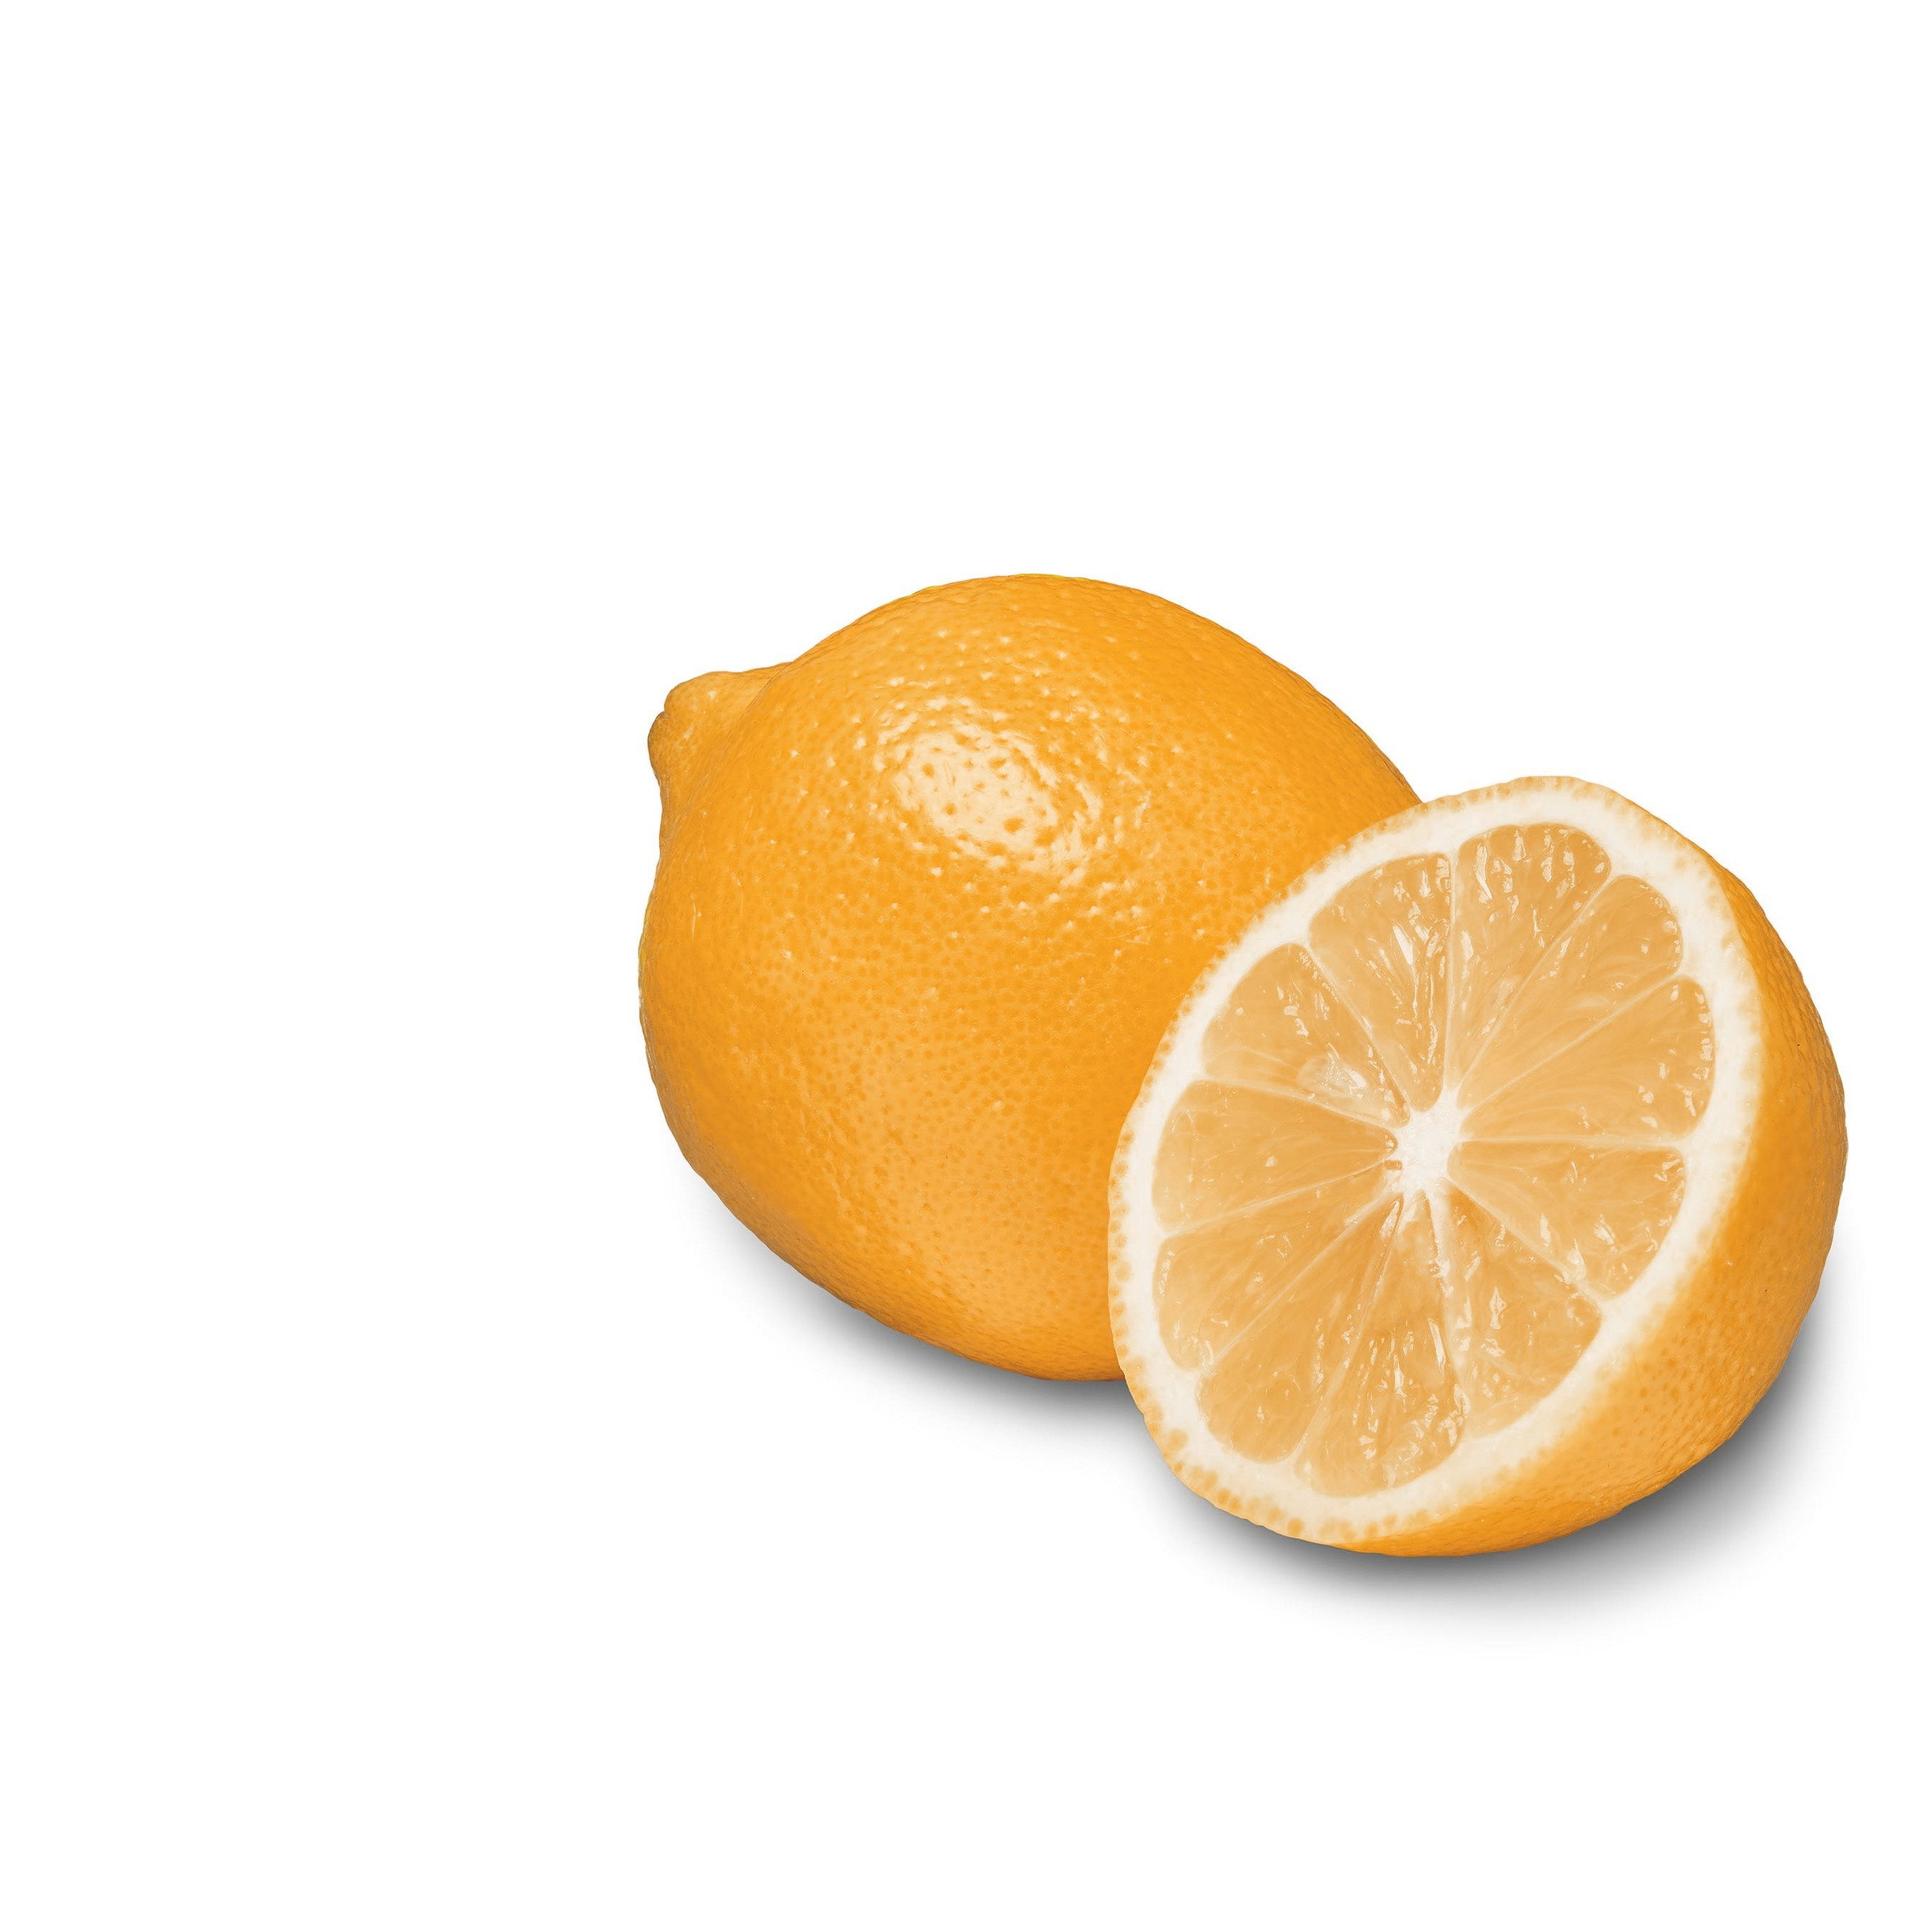

## Testing with ResNet50

In [6]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.eval();
model = resnet50

In [7]:
def lemon_transforms():
    """Some translations and rotations, and of course the typical normalization."""
    max_translate_factor = 0.06 
    ts = [
        torchvision.transforms.ToTensor(),
        # Do rotation first so that we have more control over the center position.
        torchvision.transforms.RandomRotation(50, fill=1.0),
        torchvision.transforms.RandomAffine(degrees=0,
                                            translate=(max_translate_factor, 
                                                       max_translate_factor),
                                           fill=1.0),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        torchvision.transforms.Resize((224, 224))]
    return torchvision.transforms.Compose(ts)

def class_id_to_label(i):
    return labels[i]

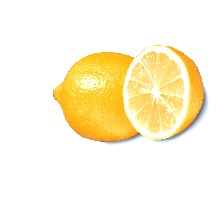

tensor([951]), lemon


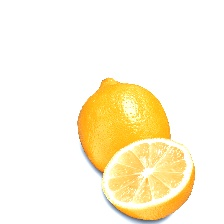

tensor([951]), lemon


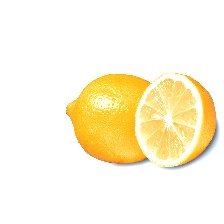

tensor([951]), lemon


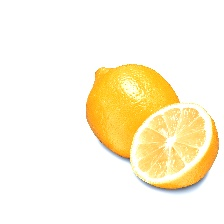

tensor([951]), lemon


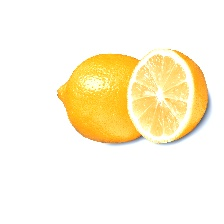

tensor([951]), lemon


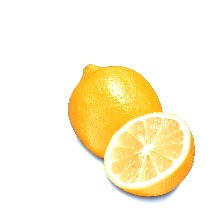

tensor([951]), lemon


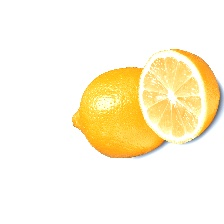

tensor([951]), lemon


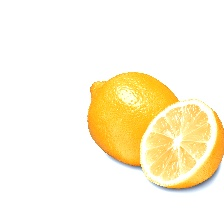

tensor([951]), lemon


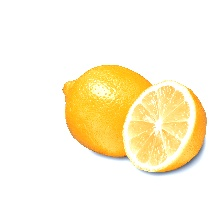

tensor([951]), lemon


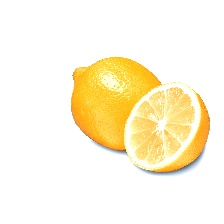

tensor([951]), lemon


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
# The single edited photo is put into ./resources/oranges/1/. The folder structure is 
# organized like this to placate the ImageFolder class.
lemon_ds = torchvision.datasets.ImageFolder('./resources/oranges/', lemon_transforms())
dl = torch.utils.data.DataLoader(lemon_ds, batch_size=1)
for i in range(10):
    plt.figure()
    img = next(iter(dl))[0]
    class_id = torch.argmax(model.forward(img), dim=1)
    #plt.imshow(img_tensor.permute(1, 2, 0)/3 + 0.5)
    imshow((img[0].permute(1, 2, 0)/3 + 0.5).numpy())
    print(f'{class_id}, {class_id_to_label(class_id)}')


## Results
The lemon, edited to look more orange, is reliably classified as a lemon. 

Note: the images printed in the testing loop are a bit discolored when viewing due to the normalization. 

## Limitations
The experiment is limited by many things:
- testing only one class-pair
- testing only one pre-transformed image
- testing only one edit

## So what?
Zooming-out for a moment, I would _like_ to be able to say something like: 

> "ResNet50 trained on ImageNet doesn't rely heavily on color to classify images."

My hunch is that this is true, and I feel that the results of this experiment act as some little bit of evidence to suggest that it is so.